# Face Recognition Project

В этом проекте вы познакомитесь с задачей распознавания лиц, узнаете, как ее решать, и построите свой пайплан для решения этой задачи.

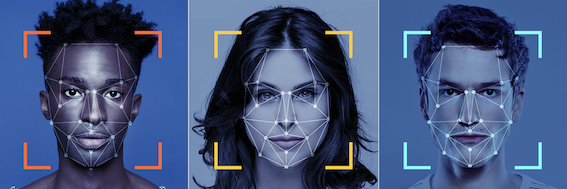

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии. После этого в разделе "задача проекта" расписано то, что нужно/можно делать в рамках этого проекта. **Пожалуйста, перед началом работы по проекту внимательно прочитайте раздел "задача проекта"!**

Ну а перед этим всем лучше разберемся с тем, какую задачу вообще мы хотим решать.

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

## Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

#### Детекция лиц

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

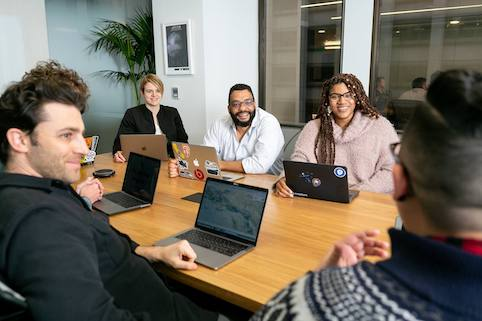

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

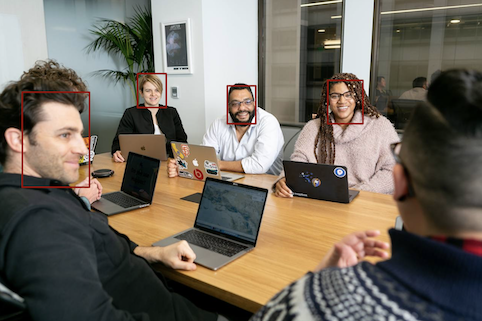

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

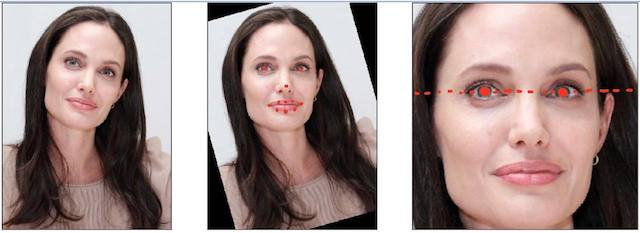

Таким образом, после второго этапа лица выглядят как-то так:

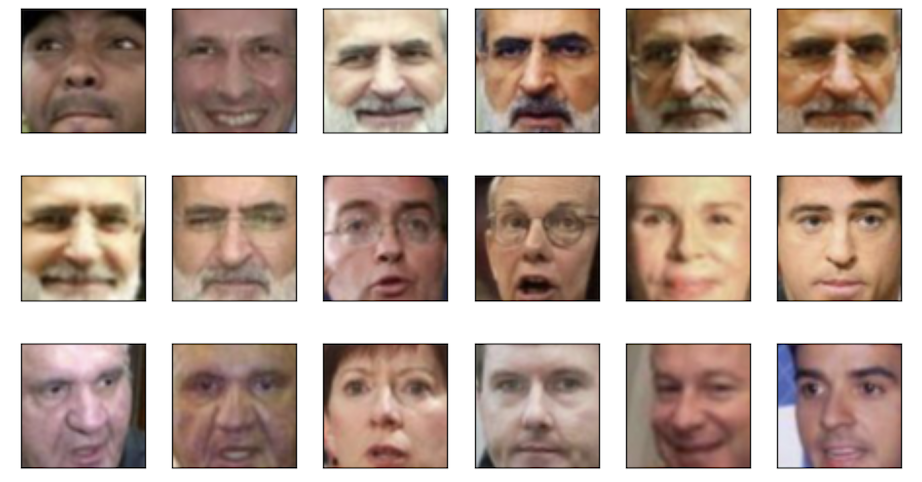

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.

#### Распознавание лиц

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не построить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



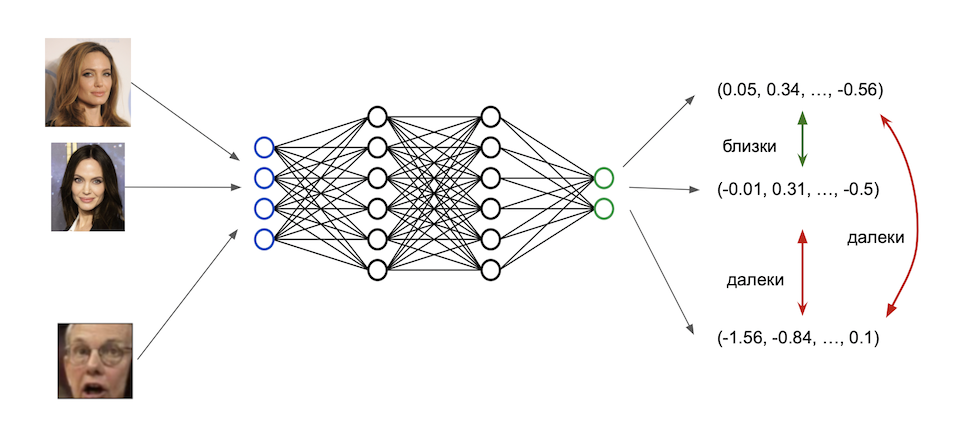

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем в задании 2). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

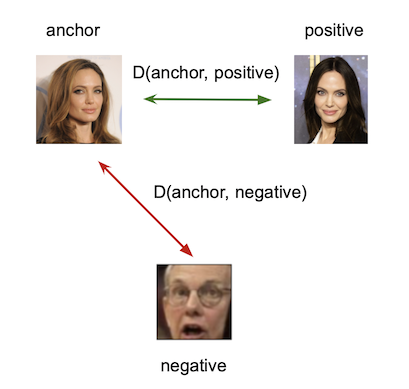

Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.
- первая часть — это просто задача детекции;
- вторая часть — задача выравнивания фотографии лица;
- третья часть — задача распознавания лица по выровненной фотографии.

## Задача проекта

 Основная задача проекта — **реализовать систему распознавания лиц своими руками**. Вот что можно делать:


**Обязательные задания:**

1.   (3 балла) Реализовать и обучить Stacked Hourglass Network для поиска ключевых точек лица, а также написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. реализовать вторую часть пайплайна face recognition) [ноутбук к заданию](https://colab.research.google.com/drive/1fjNogIx8wIFVEwr5Njf5Da1-OyPMW8A3?usp=sharing);
2.   (2 балла) Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Далее нужно реализовать ArcFace Loss и обучить такую же модель на нем. **Нельзя брать нейросети, которые уже предобучены на распознавание лиц!** В обоих случаях добиться достаточного качества классификации. [ноутбук к заданию](https://colab.research.google.com/drive/1auuuIz-1LJAjeibFK7M8Di_41nh7JcQM?usp=sharing);
3.   (1 балл) Собрать весь пайплайн распознавания лиц. На вход этому пайплайну должна подаваться картинка с лицами, а на выходе должны быть эмбеддинги всех найденных лиц. Используйте любой предобученный на лицах детектор для первого этапа, а для второго и третьего возьмите ваши модели из заданий 1 и 2. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами.

**Дополнительные задания:**

1. (2 балла) Реализовать Identification Rate Metric. [ноутбук к заданию](https://colab.research.google.com/drive/1sjO2-N8EsLb2HQcOELikFQCqKUWrPehJ?usp=sharing);
2. (2 балла) Реализовать Triplet loss (предпочтительно) или любой другой актуальный для задачи Face Recognition loss, обучить сеть на нем. Добиться достаточного качества классификации [ноутбук к заданию](https://colab.research.google.com/drive/1Vyv9vgoGYa3YGiK1QSxepckpBamFA7uB?usp=sharing);
3. (1 балл) Обучить сеть на смеси ArcFace и лосса из задачи 2. Добиться достаточного качества классификации;
4. (2 балла) Провести ресерч по open-source решениям для задачи Face Recognition. Отобрать 3 актуальные библиотеки. Сделать текстовое описание каждой из них: написать про возможности и преимущества, сложность установки, требования к вычислительным ресурсам и всё прочее интересное, в том числе и, возможно, ваше мнение. Для каждой библиотеки нужно привести примеры кода для запуска этого решения, протестировав на своих изображениях;
5. Используйте более нестандартные и продвинутые техники в процессе выполнения заданий, то есть сильно выходящие за рамки того, что описано в ноутбуке. Но если вы решили использовать что-то подобное, то должны это явно прописать, указать место в коде, где это используется и дать ссылки на то, откуда была взята эта идея. В зависимости от сложности, нестандартности и итоговой эффективности реализованной техники, работе могут быть добавлены дополнительные баллы.

**P.S. "достаточное качество классификации" соответствует accuracy >= 0.7**

**Каждое задание нужно выполнять в отдельном ноутбуке или .py файле!** По итогу работы над проектом вам нужно будет сделать Github репозиторий со всеми решенными заданиями. Также, обязательно сделайте README файл с пояснениями, где что лежит, и куда нужно смотреть. Хотелось бы, чтобы у проверяющего не возникло никаких вопросов по структуре репозитория.

К некоторым заданиям приложены сопроводительные ноутбуки с дополнительной информацией. Перед началом выполнения проекта обязательно посмотрите их все.

**Пожалуйста, пишите подробные комментарии к своему коду**. Вставляйте ссылки на статьи, где нашли какие-то трюки. Объясняйте, почему реализовали что-то именно так. Будет классно, если вы опишете свой путь в экспериментах при работе с обучением моделей: что получилось сразу, а над чем долго просидели.

**Максимум можно получить до 10 баллов. Чтобы проект считался сданным, нужно набрать 5 или более баллов и сделать все обязательные задания.**  

Сразу пояснение: за обязательные задания можно набрать $2+3+1=6$ баллов, а для зачета по проекту нужно только 5. Значит ли это, что можно сделать идеально только первые 2 задания, получив 5 баллов, и не делать третье? Нет. Без обязательных заданий проект не будет засчитан. Зазор в 1 балл сделан для того, чтобы у вас было хоть какое-то право на ошибку, чтобы не получилась ситуация, что вы сделали все необходимые задания, но из-за небольших недочетов не смогли сдать проект.

Постарайтесь сделать какие-нибудь дополнительные задания. Они не такие сложные, как может показаться, при этом вы можете получить сопоставимое с основной частью количество баллов.


**УДАЧИ!**

**У вас все получится!** 💗
